# CS207 Final Project Presentation - Group 4

# Motivation

Many of the chemical processes important to industry and to our everyday lives, such as combustion, are complex, involving multiple reactions and species. Chemical kinetics allows us to analyze how reaction rates and species concentrations evolve over time and vary with initial conditions. This analysis often requires numerical methods, motivating the development of a Python 3 library that can:
* Compute reaction rates for reaction systems of arbitrary size
* Solve coupled reaction rate ODEs to determine how reaction rates and species concentrations evolve with time
* Visualize the computed results to facilitate understanding of production yields and how quickly the system evolves


## Library installation

It's super easy to install our library. Just one-line pip command:
```bash
pip install pychemkin

```

If you want to run tests, do the following:
```bash

git clone https://github.com/cs207group4/cs207-FinalProject.git

cd cs207-FinalProject

python setup.py test

```

## Basic Functionality

The core function of the library is to calculate reaction rates for an arbitrarily-sized system of elementary reactions. Both reversible and irreversible reactions are allowed. Thermodynamic data from all species come from NASA and are stored in an sqlite database. The following example uses an xml file containing irreversible reactions, reversible reactions and species from the extended NASA database. 



In [8]:
import sys
sys.path.append('../')
import numpy as np
from pychemkin import chemkin, ChemSolver, ChemViz, simpleIO
rxnsystem = chemkin('demo_xml/demo.xml')

print(rxnsystem.summary())

Finished reading xml input file
chemical equations:
[
H + O2 [=] O + OH
O + H2 [=] H + OH
H2 + OH [=] H2O + H
O + H2O [=] OH + OH
HO2 + H [=] H2 + O2
HO2 + H [=] OH + OH
HO2 + O [=] O2 + OH
HO2 + OH [=] H2O + O2
H2O2 + H [=] H2O + OH
H2O2 + H [=] HO2 + H2
H2O2 + O [=] OH + HO2
]
species: ['H', 'O', 'OH', 'H2', 'H2O', 'O2', 'HO2', 'H2O2']
reversible: [ True  True  True  True  True  True  True  True  True  True  True]


In [9]:
T = 1500 #temperature in K
x = np.ones(8)
print("Progress rates")
print(rxnsystem.progress_rate(x,T))
print("Reaction rates")
print(rxnsystem.reaction_rate(x,T))

Progress rates
[ -7.38714255e+14   1.23527805e+12   9.96158478e+12  -7.75669761e+13
   1.55398791e+13   6.91350963e+13   3.24999993e+13   3.00749937e+13
   1.75292917e+13   2.54452663e+13   1.56107935e+13]
Reaction rates
[  6.22261584e+14  -7.10493349e+14  -7.28739230e+14   2.97882825e+13
   1.35132846e+14   8.16829127e+14  -1.06193909e+14  -5.85853515e+13]


## Chemkin Solver

Our reaction rate function returns the right-hand side of a system of coupled ODEs, 

$$\frac{d\textbf{x}}{dt} = \text{reaction_rate}(\textbf{x}, t), $$
where $\textbf{x}$ is a vector of species concentrations and $t$ is the time.

A natural question is to ask - how do the reaction rates and concentrations vary with time? If one is interested in improving product yields, minimizing the formation of byproducts, or investigating the efficiency of particular combinations of species, it is essential to understand the time evolution of the reaction system. 

In order to solve these ODEs, we created a ChemSolver class that wraps around the SciPy library's scipy.integrate.ode function. The user can choose among several algorithms offered by SciPy, including ```vode```, ```lsoda```, ```dop853```, and ```dopri5```. By default, we use the ```lsoda``` algorithm, which switches automatically between methods optimized for stiff and non-stiff problems. Reaction rate systems are often [stiff](https://blogs.mathworks.com/cleve/2014/06/09/ordinary-differential-equations-stiffness/), but in intervals when the system is not stiff, using non-stiff methods may be more efficient.  

In [10]:
# Solve an ODE
x_init = np.ones(8)
T = 1000

# integration end time in seconds
t_max = 5.e-13

# step size in seconds
dt = 1.e-16

cs = ChemSolver(chemkin('demo_xml/rxns_reversible.xml'))
cs.solve(x_init, T, t_max, dt)

Finished reading xml input file


In [11]:
# The results are stored as a tuple (time, concentration, reaction_rate)
cs.get_results()

(array([  0.00000000e+00,   1.00000000e-16,   2.00000000e-16, ...,
          4.99700000e-13,   4.99800000e-13,   4.99900000e-13]),
 array([[  1.00000000e+00,   1.40388889e+00,   1.55609804e+00, ...,
           6.09750660e-01,   6.09796468e-01,   6.09842274e-01],
        [  1.00000000e+00,   5.99803862e-01,   4.36896442e-01, ...,
           1.76166676e-01,   1.76175623e-01,   1.76184570e-01],
        [  1.00000000e+00,   5.59552587e-01,   3.96471743e-01, ...,
           4.10495501e-02,   4.10501341e-02,   4.10507181e-02],
        ..., 
        [  1.00000000e+00,   1.42459887e+00,   1.59903351e+00, ...,
           2.99842617e+00,   2.99839404e+00,   2.99836191e+00],
        [  1.00000000e+00,   9.87753069e-01,   9.75570303e-01, ...,
           1.41006348e-05,   1.40704613e-05,   1.40403501e-05],
        [  1.00000000e+00,   9.95405296e-01,   9.90154609e-01, ...,
           4.15874316e-05,   4.14983003e-05,   4.14093535e-05]]),
 array([[  7.18613864e+15,   2.24054331e+15,   1.01980211e+15

In [12]:
# result as a dataframe
df = cs.to_df()
#first few timesteps
df.head()

,t,H-Concentration,O-Concentration,OH-Concentration,H2-Concentration,H2O-Concentration,O2-Concentration,HO2-Concentration,H2O2-Concentration,H-Reaction_rate,O-Reaction_rate,OH-Reaction_rate,H2-Reaction_rate,H2O-Reaction_rate,O2-Reaction_rate,HO2-Reaction_rate,H2O2-Reaction_rate,T
0,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.186139e+15,-6.966219e+15,-7.885319e+15,2.922808e+13,4.208046e+14,7.376855e+15,-1.220904e+14,-3.939752e+13,1000.0
1,1.000000e-16,1.403889,0.599804,0.559553,1.003868,1.025129,1.424599,0.987753,0.995405,2.240543e+15,-2.307251e+15,-2.419883e+15,4.487272e+13,1.563024e+14,2.458111e+15,-1.223802e+14,-5.031498e+13,1000.0
2,2.000000e-16,1.556098,0.436896,0.396472,1.008660,1.037115,1.599034,0.975570,0.990155,1.019802e+15,-1.154405e+15,-1.080408e+15,5.018722e+13,9.483374e+13,1.245287e+15,-1.211582e+14,-5.413915e+13,1000.0
3,3.000000e-16,1.631130,0.347005,0.317808,1.013810,1.045306,1.696758,0.963536,0.984647,5.435176e+14,-7.024104e+14,-5.618140e+14,5.250687e+13,7.217554e+13,7.713060e+14,-1.194947e+14,-5.578688e+13,1000.0
4,4.000000e-16,1.672628,0.289049,0.275509,1.019121,1.051945,1.761044,0.951677,0.979028,3.108598e+14,-4.796844e+14,-3.109858e+14,5.356416e+13,6.182231e+13,5.385785e+14,-1.176621e+14,-5.649240e+13,1000.0


In [13]:
# We might want to know whether our system has reached equilibrium 
# is there additional information to be learned by running the simulation for more timesteps?
cs.is_equilibrium()

False

In [14]:
# save solved result as a csv file or an HDF5 file for the user to analyze later as desired
cs.save_results('result.csv')
cs.save_results('result.h5')

In [15]:
print(cs.chem.species)
# Explore different combinations of temperature values and concentration values at once
Temp_vals = [500,1000,1500]
concentrations = np.array([[1, 1, 1, 1, 1, 1, 1, 1],
                           [0, 0, 0, 1, 0, 1, 0, 0]])
gridresults = cs.grid_solve(concentrations,
               Temp_vals, 
               t_max, dt).get_grid_results()

['H', 'O', 'OH', 'H2', 'H2O', 'O2', 'HO2', 'H2O2']


In [16]:
#first part of tuple stores the parameters of the grid
print(gridresults[0])
#second part of tuple is a dictionary where the key is the temperature 
#and the value is a dictionary holding a list of ODE solutions corresponding to each set of concentrations
print(gridresults[1][500][0])

[[500, 1000, 1500], array([[1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 0, 1, 0, 0]])]
(array([  0.00000000e+00,   1.00000000e-16,   2.00000000e-16, ...,
         4.99700000e-13,   4.99800000e-13,   4.99900000e-13]), array([[  1.00000000e+00,   1.97569189e+00,   1.97642053e+00, ...,
          5.50129449e-01,   5.50125216e-01,   5.50120986e-01],
       [  1.00000000e+00,   2.09619791e-02,   1.86456412e-03, ...,
          3.44213137e-03,   3.44327032e-03,   3.44440937e-03],
       [  1.00000000e+00,   2.15827791e-03,   9.59913960e-03, ...,
          4.48003608e-04,   4.47851357e-04,   4.47699195e-04],
       ..., 
       [  1.00000000e+00,   1.99725409e+00,   2.01928736e+00, ...,
          3.22105419e+00,   3.22105544e+00,   3.22105669e+00],
       [  1.00000000e+00,   9.85717691e-01,   9.71676478e-01, ...,
          4.29900416e-04,   4.29512487e-04,   4.29124911e-04],
       [  1.00000000e+00,   9.96777006e-01,   9.93550028e-01, ...,
          3.82360536e-03,   3.82015729e-03,   3.8167

In [17]:
#save grid results to output file
cs.save_grid_results('demogridexample', filetype = 'csv')


In [18]:
# load from file -- csv or hdf5. Useful when solving ODE takes long time
#this only works for single simulation mode
cs = ChemSolver(chemkin('demo_xml/rxns_reversible.xml')).load_results('result.csv')
cs.to_df().head()

Finished reading xml input file


,t,H-Concentration,O-Concentration,OH-Concentration,H2-Concentration,H2O-Concentration,O2-Concentration,HO2-Concentration,H2O2-Concentration,H-Reaction_rate,O-Reaction_rate,OH-Reaction_rate,H2-Reaction_rate,H2O-Reaction_rate,O2-Reaction_rate,HO2-Reaction_rate,H2O2-Reaction_rate,T
0,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.186139e+15,-6.966219e+15,-7.885319e+15,2.922808e+13,4.208046e+14,7.376855e+15,-1.220904e+14,-3.939752e+13,1000.0
1,1.000000e-16,1.403889,0.599804,0.559553,1.003868,1.025129,1.424599,0.987753,0.995405,2.240543e+15,-2.307251e+15,-2.419883e+15,4.487272e+13,1.563024e+14,2.458111e+15,-1.223802e+14,-5.031498e+13,1000.0
2,2.000000e-16,1.556098,0.436896,0.396472,1.008660,1.037115,1.599034,0.975570,0.990155,1.019802e+15,-1.154405e+15,-1.080408e+15,5.018722e+13,9.483374e+13,1.245287e+15,-1.211582e+14,-5.413915e+13,1000.0
3,3.000000e-16,1.631130,0.347005,0.317808,1.013810,1.045306,1.696758,0.963536,0.984647,5.435176e+14,-7.024104e+14,-5.618140e+14,5.250687e+13,7.217554e+13,7.713060e+14,-1.194947e+14,-5.578688e+13,1000.0
4,4.000000e-16,1.672628,0.289049,0.275509,1.019121,1.051945,1.761044,0.951677,0.979028,3.108598e+14,-4.796844e+14,-3.109858e+14,5.356416e+13,6.182231e+13,5.385785e+14,-1.176621e+14,-5.649240e+13,1000.0


## Chemkin Solver Visualization

We implemented a `ChemViz` class which helps to visualize calculations stored in a ChemSolver object. Reaction rates and concentrations of species can be plotted as a function of time, allowing one to quickly assess:
* whether solutions look reasonable (e.g., by examining the smoothness of the curve)
* visually heck whether the system is at equilibrium or close to equilibrium
* identify which species rapidly form or get destroyed versus which species remain relatively steady in concentration

Whereas the time series plots focus on the individual species, the network diagrams provide complementary information about how the species interact with one another. 

We show some examples in the next few slides. 

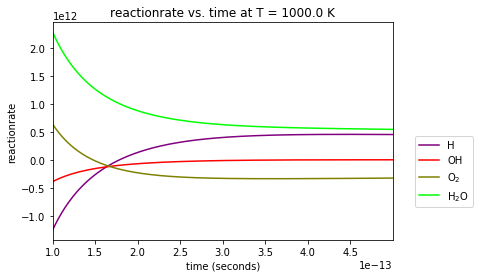

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
cv = ChemViz(cs)
#species and time range can be chosen arbitrarily
cv.plot_time_series("reactionrate",tmin=1.e-13, species = ['H', 'OH', 'O2', 'H2O'])

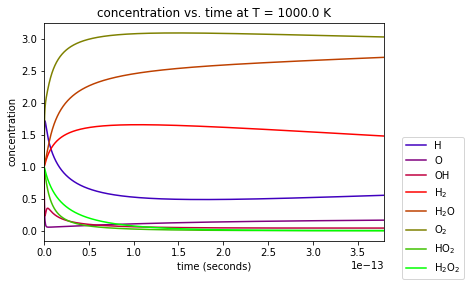

In [20]:
cv.plot_time_series("concentration",tmax=3.8e-13)

['H', 'O', 'OH', 'H2', 'H2O', 'O2', 'HO2', 'H2O2']


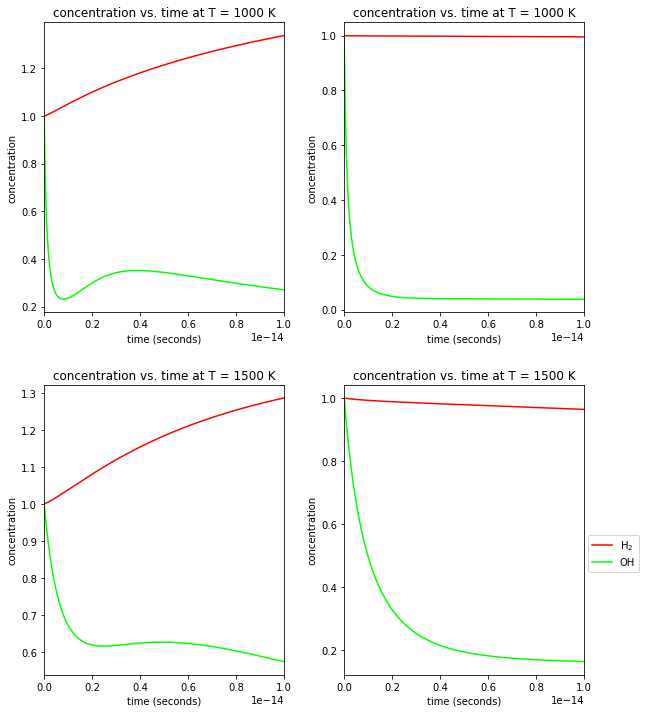

In [21]:
print(cs.chem.species)
Temp_vals = [1000,1500]
concentrations = np.array([[1,1,1,1,1,1,1,1],
                           [1,1,1,1,0,0,0,0]])
t_max = 2.e-14
dt = 2.5e-17
gridresults = cs.grid_solve(concentrations,
               Temp_vals, 
               t_max, dt).get_grid_results()
cv.plot_gridtime_series("concentration", tmax = 1e-14, species = ['H2', 'OH'])

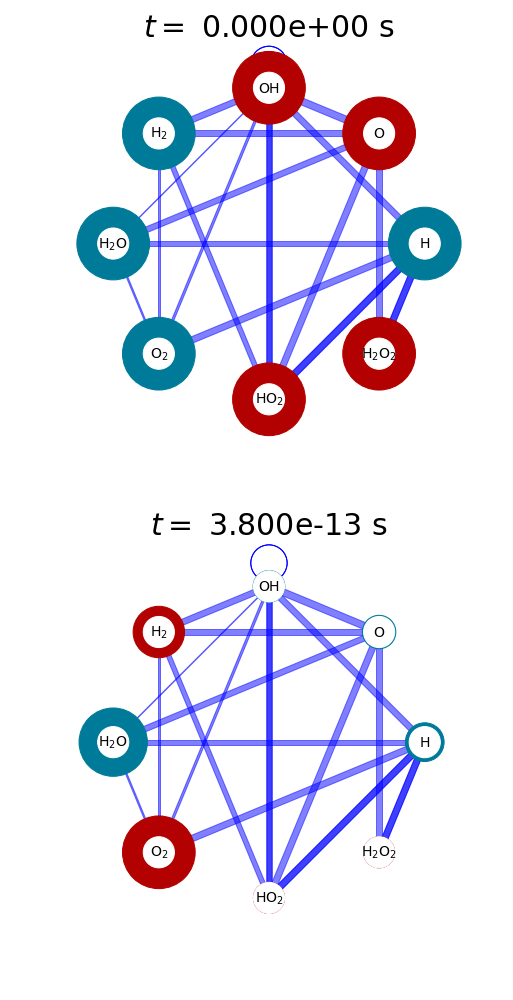

In [22]:
#networks can be plotted for arbitrary time points
#species are connected to one another if they react with one another (including backwards reactions)
#the lines are weighted logarithmically by the reaction rate coefficients
#the bubbles are linearly scaled by the concentrations
#red bubbles are decreasing in concentration and blue bubbles are increasing in concentration
cv.plot_network([0, 3.8e-13])

In [23]:
cs = ChemSolver(chemkin('demo_xml/rxns_reversible.xml')).load_results('result.csv')
cv = ChemViz(cs)
cv.html_report('report.html')

Finished reading xml input file


After running the above code, an HTML report will be generated as <a href="report.html" target="_blank">report.html</a>


## simpleIO

We implemented a `simpleIO` class which can save and load objects...(insert presentation scripts here...)

In [24]:
#save the ChemSolver object
simpleIO('cs.pkl').to_pickle(cs)
cs2 = simpleIO('cs.pkl').read_pickle()
cs2.to_df().head()

,t,H-Concentration,O-Concentration,OH-Concentration,H2-Concentration,H2O-Concentration,O2-Concentration,HO2-Concentration,H2O2-Concentration,H-Reaction_rate,O-Reaction_rate,OH-Reaction_rate,H2-Reaction_rate,H2O-Reaction_rate,O2-Reaction_rate,HO2-Reaction_rate,H2O2-Reaction_rate,T
0,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.186139e+15,-6.966219e+15,-7.885319e+15,2.922808e+13,4.208046e+14,7.376855e+15,-1.220904e+14,-3.939752e+13,1000.0
1,1.000000e-16,1.403889,0.599804,0.559553,1.003868,1.025129,1.424599,0.987753,0.995405,2.240543e+15,-2.307251e+15,-2.419883e+15,4.487272e+13,1.563024e+14,2.458111e+15,-1.223802e+14,-5.031498e+13,1000.0
2,2.000000e-16,1.556098,0.436896,0.396472,1.008660,1.037115,1.599034,0.975570,0.990155,1.019802e+15,-1.154405e+15,-1.080408e+15,5.018722e+13,9.483374e+13,1.245287e+15,-1.211582e+14,-5.413915e+13,1000.0
3,3.000000e-16,1.631130,0.347005,0.317808,1.013810,1.045306,1.696758,0.963536,0.984647,5.435176e+14,-7.024104e+14,-5.618140e+14,5.250687e+13,7.217554e+13,7.713060e+14,-1.194947e+14,-5.578688e+13,1000.0
4,4.000000e-16,1.672628,0.289049,0.275509,1.019121,1.051945,1.761044,0.951677,0.979028,3.108598e+14,-4.796844e+14,-3.109858e+14,5.356416e+13,6.182231e+13,5.385785e+14,-1.176621e+14,-5.649240e+13,1000.0


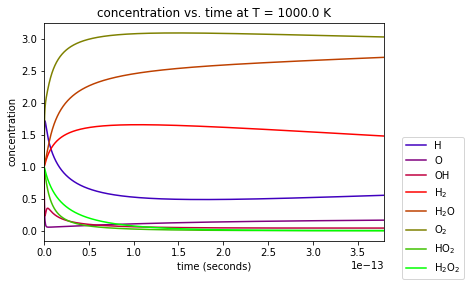

In [25]:
#save the ChemViz object
simpleIO('cv.pkl').to_pickle(cv)
cv2 = simpleIO('cv.pkl').read_pickle()
cv2.plot_time_series("concentration",tmax=3.8e-13)